# Assignment 2: Computing Trust Rank


| Name             | Roll Number       |
|------------------|-------------------|
| **Popat Raj R**  | CS23MTECH14009    |
| **Yash Shukla**  | CS23MTECH14018    |
| **Vaibhav Shah** | AI23MTECH02007    |
| **Sreyash Mohanty** | CS23MTECH14015  |
| **Somya Kumar** | SM23MTECH11010  |

## Overview
This notebook presents an Computing trust rank for the transaction dataset were transaction data and bad senders data is given


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path_1 = "/Payments_task2.csv"
file_path_2 = "/bad_sender_task2.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the datasets
transactions_data = pd.read_csv(file_path_1)
bad_senders_data = pd.read_csv(file_path_2)

# Graph Creation and visualization in 2D and 3D

The following code cell constructs a directed graph from the transaction dataset. This graph represents transactions where each node is a participant (either a sender or receiver), and each edge indicates a transaction direction from sender to receiver.


In [ ]:
# Create the graph
G = nx.from_pandas_edgelist(transactions_data, 'Sender', 'Receiver', create_using=nx.DiGraph())

# Assign initial trust scores
initial_trust = {node: 0.0001 if node in bad_senders_data['Bad Sender'].values else 1 for node in G.nodes()}

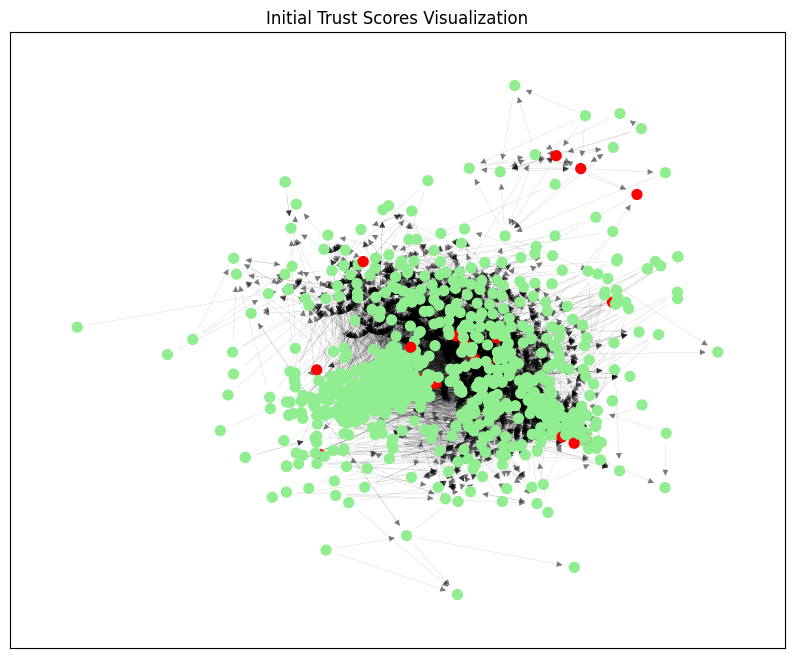

In [ ]:
# Visualize the graph with initial trust scores
pos = nx.kamada_kawai_layout(G)
node_colors = ['lightgreen' if score >= threshold else 'red' for node, score in [(n,initial_trust[n]) for n in G.nodes()]]

# Plotting
plt.figure(figsize=(10, 8))

# Draw nodes with specified colors
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=50)

# Draw edges with alpha set to 0.5
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.1,arrowstyle='-|>', arrowsize=10,)

plt.title('Initial Trust Scores Visualization')
plt.show()

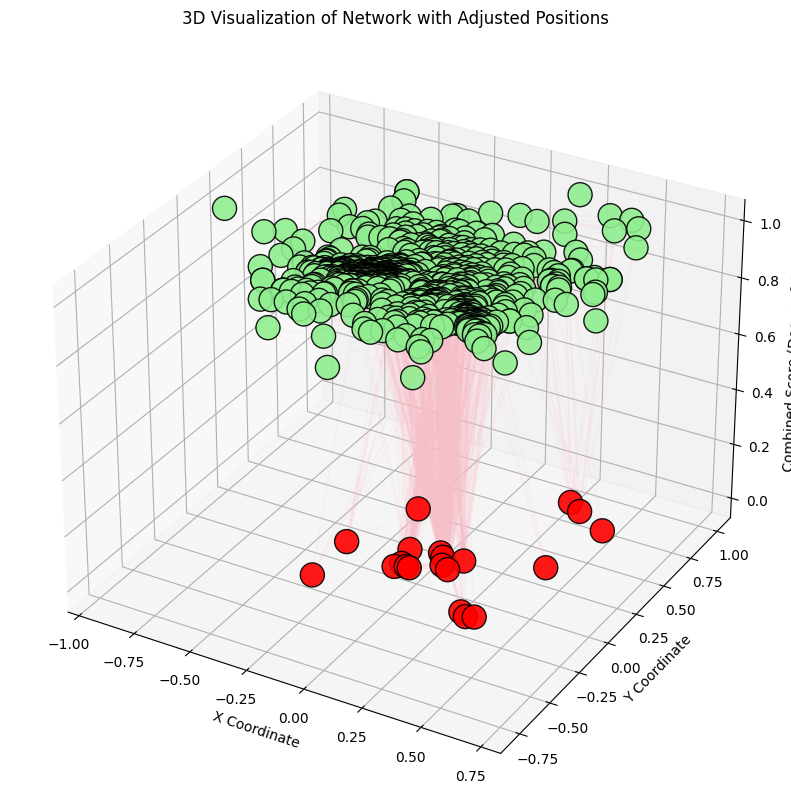

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Node colors based on threshold
threshold = 0.5
node_colors = ['lightgreen' if initial_trust[node] >= threshold else 'red' for node in G.nodes()]
pos_3d = {node: (pos[node][0], pos[node][1], initial_trust[node]) for node in G.nodes()}

# Extract the positions
x = np.array([pos_3d[node][0] for node in G.nodes()])
y = np.array([pos_3d[node][1] for node in G.nodes()])
z = np.array([pos_3d[node][2] for node in G.nodes()])

# Draw nodes
sc = ax.scatter(x, y, z, c=node_colors, s=300, edgecolors='k', alpha=0.9)

# Draw edges
for edge in G.edges():
    x = np.array((pos_3d[edge[0]][0], pos_3d[edge[1]][0]))
    y = np.array((pos_3d[edge[0]][1], pos_3d[edge[1]][1]))
    z = np.array((pos_3d[edge[0]][2], pos_3d[edge[1]][2]))
    ax.plot(x, y, z, "pink", alpha=0.1)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Combined Score (Degree & Trust)')
plt.title('3D Visualization of Network with Adjusted Positions')
plt.show()


# Trust Score Propagation

This section defines a function to propagate trust scores within the graph. The function iterates over all nodes, updating their trust scores based on the trust scores of their predecessors (nodes that have transactions directed towards the node in question).

- **Isolated Nodes:** Nodes without incoming edges retain their initial trust scores or receive a slight adjustment if their initial score is undefined.
- **Non-isolated Nodes:** For each node with incoming transactions, the trust score is updated by aggregating the trust scores of its predecessors, applying a damping factor to moderate the influence of each iteration.
- **Convergence:** The process continues iteratively, allowing the trust scores to propagate through the network, until the maximum number of iterations is reached or the scores converge.

The result is a set of final trust scores for each node, representing their trustworthiness based on the network's transaction dynamics.


In [ ]:
def propagate_trust(G, initial_trust, damping_factor=0.99, max_iter=5000):
    trust_scores = initial_trust.copy()
    for _ in range(max_iter):
        new_trust_scores = trust_scores.copy()
        for node in G.nodes():
            if G.in_degree(node) == 0:
                # Nodes with no incoming edges maintain their initial trust score or are slightly adjusted
                new_trust_scores[node] = initial_trust.get(node, 0.1)  # Adjust as necessary

            elif trust_scores[node]!=0.0001:
                incoming_trust = sum(trust_scores[neighbor] for neighbor in G.predecessors(node))

                new_trust_scores[node] = (1 - damping_factor) + damping_factor * incoming_trust / G.in_degree(node)
        trust_scores = new_trust_scores
    return trust_scores

final_trust_scores = propagate_trust(G, initial_trust)

In [ ]:
# Example of analyzing results
threshold = 0.6  # Set based on distribution of trust scores or expert input
bad_nodes = [node for node, score in final_trust_scores.items() if score < threshold]
good_nodes = [node for node, score in final_trust_scores.items() if score >= threshold]

print(len(bad_nodes),len(good_nodes))

34 765


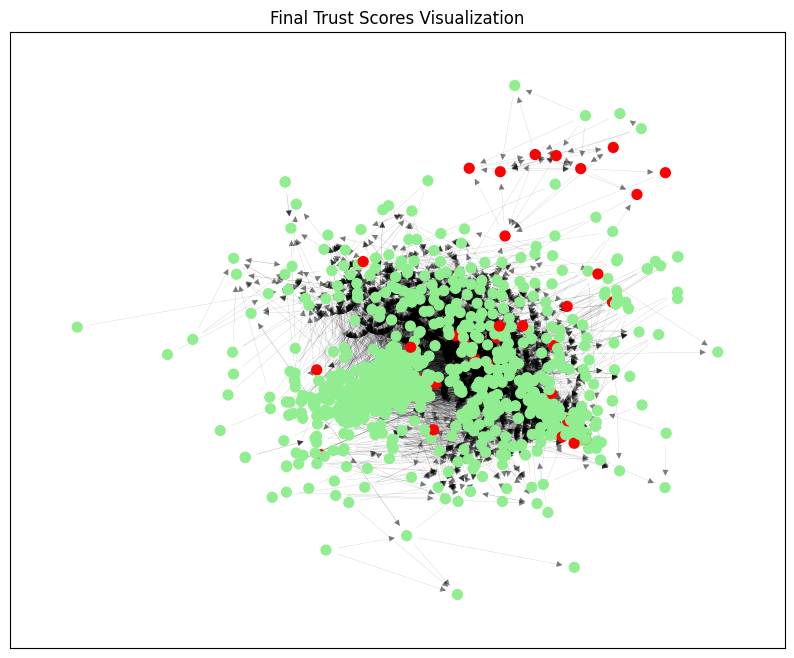

In [ ]:
node_colors = ['lightgreen' if score >= threshold else 'red' for node, score in final_trust_scores.items()]

# Plotting
plt.figure(figsize=(10, 8))

# Draw nodes with specified colors
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=50)

# Draw edges with alpha set to 0.5
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.1)

plt.title('Final Trust Scores Visualization')
plt.show()

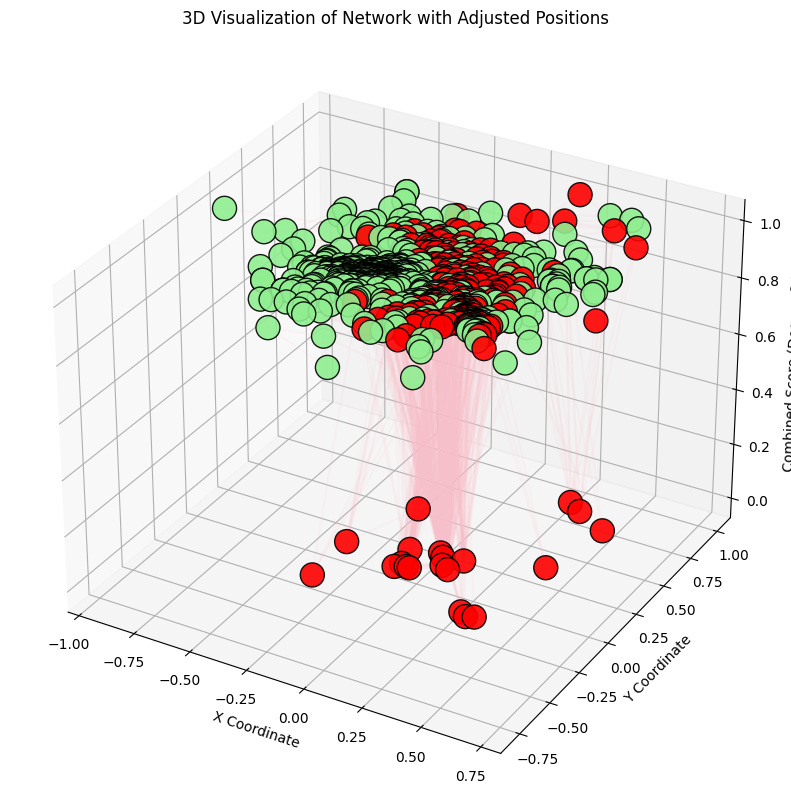

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Node colors based on threshold
threshold = 0.9
node_colors = ['lightgreen' if score >= threshold else 'red' for node, score in final_trust_scores.items()]
pos_3d = {node: (pos[node][0], pos[node][1], initial_trust[node]) for node in G.nodes()}

# Extract the positions
x = np.array([pos_3d[node][0] for node in G.nodes()])
y = np.array([pos_3d[node][1] for node in G.nodes()])
z = np.array([pos_3d[node][2] for node in G.nodes()])

# Draw nodes
sc = ax.scatter(x, y, z, c=node_colors, s=300, edgecolors='k', alpha=0.9)

# Draw edges
for edge in G.edges():
    x = np.array((pos_3d[edge[0]][0], pos_3d[edge[1]][0]))
    y = np.array((pos_3d[edge[0]][1], pos_3d[edge[1]][1]))
    z = np.array((pos_3d[edge[0]][2], pos_3d[edge[1]][2]))
    ax.plot(x, y, z, "pink", alpha=0.1)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Combined Score (Degree & Trust)')
plt.title('3D Visualization of Network with Adjusted Positions')
plt.show()

# Evaluation Metrics for Trust Scores

This section of the notebook introduces functions to evaluate the effectiveness of the trust scores derived from the graph. The evaluation is based on precision, recall, and orderedness metrics:

## Precision and Recall Calculation

- **Precision**: This metric measures the accuracy of the predicted bad nodes against the trust scores. It calculates the proportion of predicted bad nodes that are correctly identified as bad (true positives) relative to all nodes predicted as bad.
- **Recall**: This metric assesses the completeness, quantifying the proportion of actual bad nodes that were correctly identified based on the trust scores.

These metrics help in understanding how well the trust scores can distinguish between bad and non-bad nodes using a defined threshold.

## Pairwise Orderedness

- **Orderedness**: This function calculates the orderedness of the network based on the trust scores. It compares all possible pairs of nodes and checks if pairs involving a bad node have a lower trust score compared to a non-bad node. The overall orderedness is the proportion of pairs that correctly reflect the expected order (non-bad nodes should have higher trust scores than bad nodes).

The orderedness provides insight into the global reliability of the trust scores across the network, indicating how consistently the scores reflect the actual trustworthiness of nodes.

## Execution

Given the final trust scores and a list of identified bad nodes, the notebook computes:
- Precision and recall using a threshold to classify nodes as bad based on their trust scores.
- Orderedness to assess how well the trust scores order nodes from non-bad to bad across the entire network.

The results of these metrics are printed to provide a quantitative assessment of the trust score model's effectiveness.


In [ ]:
import numpy as np

def calculate_precision_recall(trust_scores, bad_nodes, threshold):
    predicted_bad = [node for node, score in trust_scores.items() if score < threshold]
    actual_bad = set(bad_nodes)

    true_positives = len(set(predicted_bad) & actual_bad)
    precision = true_positives / len(predicted_bad) if predicted_bad else 0
    recall = true_positives / len(actual_bad) if actual_bad else 0

    return precision, recall

def calculate_pairwise_orderedness(trust_scores, nodes):
    # Generate all pairs of nodes
    from itertools import combinations
    node_pairs = list(combinations(nodes, 2))

    violations = 0
    for n1, n2 in node_pairs:
        if trust_scores[n1] < trust_scores[n2] and n1 in bad_nodes and n2 not in bad_nodes:
            violations += 1
        elif trust_scores[n1] > trust_scores[n2] and n1 not in bad_nodes and n2 in bad_nodes:
            violations += 1

    orderedness = 1 - (violations / len(node_pairs))
    return orderedness

# Assuming 'final_trust_scores' and 'bad_nodes' are already defined
threshold = 0.6
precision, recall = calculate_precision_recall(final_trust_scores, bad_nodes, threshold)
orderedness = calculate_pairwise_orderedness(final_trust_scores, list(G.nodes()))

print(f"Precision: {precision}, Recall: {recall}, Orderedness: {orderedness}")

Precision: 1.0, Recall: 1.0, Orderedness: 0.9184130539113742


# Precision and Recall Curve

This section of the notebook visualizes how precision and recall vary with different thresholds in the TrustRank scores. The plot helps in identifying an optimal threshold value for classifying nodes as bad senders.

## Steps Involved:

1. **Data Preparation**:
   - Extract trust scores and corresponding labels (1 for bad senders and 0 otherwise) from the dataset.
   - Sort the nodes by their TrustRank scores for sequential threshold evaluation.

2. **Precision and Recall Calculation**:
   - Iterate over each sorted node to simulate varying the threshold from the lowest to the highest TrustRank score.
   - For each node, update counts of true positives (TP) and false positives (FP) as the threshold includes more nodes.
   - Calculate precision (TP / (TP + FP)) and recall (TP / total actual bad senders) at each step.

3. **Plotting**:
   - Plot precision and recall against the TrustRank score thresholds.
   - This curve provides a visual tool to assess the trade-offs between precision and recall across different thresholds, aiding in the selection of an optimal cut-off point for classifying nodes.

The generated plot displays how closely the trust scores can predict bad senders and allows for a detailed analysis of the effectiveness of the TrustRank algorithm at various thresholds.



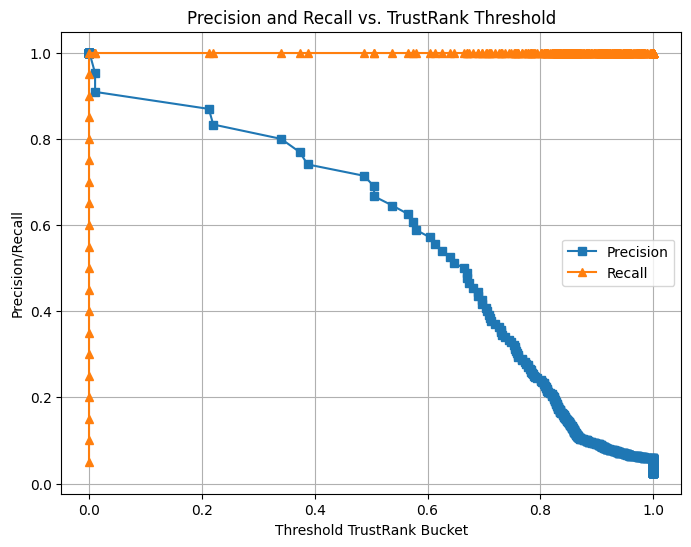

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_trust_scores and bad_senders are already defined
bad_senders_set = set(bad_senders_data['Bad Sender'].values)
nodes = list(final_trust_scores.keys())
scores = np.array([final_trust_scores[node] for node in nodes])
labels = np.array([1 if node in bad_senders_set else 0 for node in nodes])

# Sort nodes by increasing TrustRank score
indices = np.argsort(scores)
sorted_labels = labels[indices]

# Calculate precision and recall for each possible threshold
precisions = []
recalls = []
thresholds = []
total_positives = np.sum(labels == 1)

tp = 0  # True positives
fp = 0  # False positives

for i in range(len(sorted_labels)):
    if sorted_labels[i] == 1:
        tp += 1
    else:
        fp += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / total_positives if total_positives > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    thresholds.append(scores[indices[i]])

# Plotting Precision and Recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', marker='s')
plt.plot(thresholds, recalls, label='Recall', marker='^')
plt.title('Precision and Recall vs. TrustRank Threshold')
plt.xlabel('Threshold TrustRank Bucket')
plt.ylabel('Precision/Recall')
plt.legend()
plt.grid(True)
plt.show()